In [21]:
import numpy as np

import lsst.afw.image as afw_image
import lsst.afw.geom as afw_geom
from descwl_shear_sims.galaxies import make_galaxy_catalog
from descwl_shear_sims.psfs import make_fixed_psf
from descwl_shear_sims.sim import make_sim
from descwl_shear_sims.objlists import get_objlist
from descwl_shear_sims.surveys import get_survey
from descwl_shear_sims.constants import FIXED_PSF_FWHM

import matplotlib.pyplot as plt

import galsim

import emcee

from multiprocessing import Pool, set_start_method
#set_start_method('forkserver', force=True)

import gc

In [2]:
def get_coadd_center_gs_pos(coadd_wcs, coadd_bbox):
    """
    get the sky position of the center of the coadd within the
    bbox as a galsim CelestialCoord

    Parameters
    ----------
    coadd_wcs: DM wcs
        The wcs for the coadd
    coadd_bbox: geom.Box2I
        The bounding box for the coadd within larger wcs system

    Returns
    -------
    galsim CelestialCoord
    """

    # world origin is at center of the coadd, which itself
    # is in a bbox shifted from the overall WORLD_ORIGIN

    bbox_cen_skypos = coadd_wcs.pixelToSky(
        coadd_bbox.getCenter()
    )

    return galsim.CelestialCoord(
        ra=float(bbox_cen_skypos.getRa()) * galsim.radians,
        dec=float(bbox_cen_skypos.getDec()) * galsim.radians,
)

In [3]:
seed = 8312
rng = np.random.RandomState(seed)

In [4]:
# coadd_dim = 251
coadd_dim = 201
psf_dim = 51
bands = ['i']
noise_factor = 1e-3

In [5]:

# this makes a grid of fixed exponential galaxies
# with default properties. One exposure per band

galaxy_catalog = make_galaxy_catalog(
    rng=rng,
    gal_type='fixed',
    coadd_dim=coadd_dim,
    buff=30,
    layout='grid',
    gal_config={"morph": "gauss", "mag": 20}
)

In [6]:
survey = get_survey(gal_type=galaxy_catalog.gal_type, band=bands[0])
noise_for_gsparams = survey.noise*noise_factor

In [7]:
lists = get_objlist(
    galaxy_catalog=galaxy_catalog,
    survey=survey,
    star_catalog=None,
    noise=noise_for_gsparams,
)

In [8]:
# gaussian psf
psf = make_fixed_psf(psf_type='gauss')

In [9]:
# generate simulated data, see below for whats in this dict
data = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    coadd_dim=coadd_dim,
    psf_dim=psf_dim,
    bands=bands,
    g1=0.02,
    g2=0.00,
    psf=psf,
    dither=False,
    rotate=False,
    draw_method='no_pixel',
    se_dim=coadd_dim,
    noise_factor=noise_factor,
)

# data is a dict with the following keys.
# band_data: a dict, keyed by band name, with values that are a list of
#   exps
# coadd_wcs: is a DM wcs for use in coadding
# psf_dims: is the psf dim we sent in (psf_dim, psf_dim)
# coadd_dims: shape of the coadd image (dim, dim)
# coadd_bbox: is an lsst Box2I, for use in coadding
# bright_info: is a structured array with position and mask info for bright
#   objects
# se_wcs: list of WCS for each single epoch image

In [10]:
se_wcs = data['se_wcs'][0]
coadd_gs_center = get_coadd_center_gs_pos(data['coadd_wcs'], data['coadd_bbox'])
obj_x = []
obj_y = []
for shift in lists['shifts']:
    shift = shift.shear(galsim.Shear(g1=0.02, g2=0.))
    w_pos = coadd_gs_center.deproject(shift.x*galsim.arcsec, shift.y*galsim.arcsec)
    image_pos = se_wcs.toImage(w_pos)
    obj_x.append(image_pos.x)
    obj_y.append(image_pos.y)
obj_x = np.array(obj_x)
obj_y = np.array(obj_y)

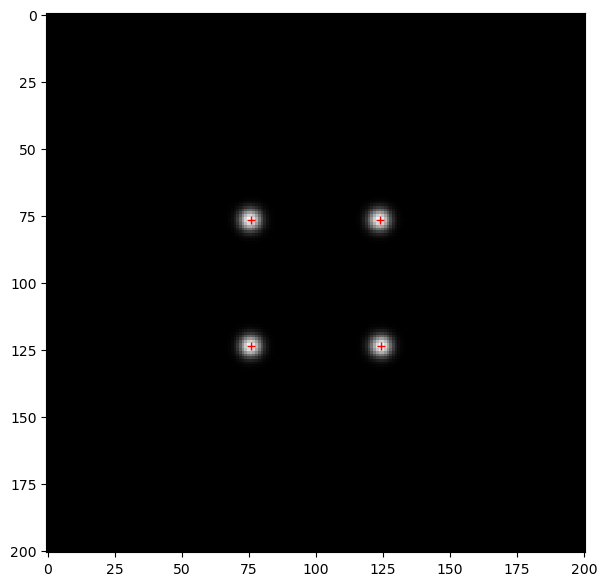

In [11]:
plt.figure(figsize=(7, 7))
plt.imshow(data['band_data']['i'][0].image.array, cmap='gray', interpolation='nearest')
plt.plot(obj_x-1, obj_y-1, 'r+')
plt.show()

In [12]:
def _coadd_sim_data(rng, sim_data, nowarp, remove_poisson):
    """
    copied from mdet-lsst-sim
    """
    from descwl_coadd.coadd import make_coadd
    from descwl_coadd.coadd_nowarp import make_coadd_nowarp
    from metadetect.lsst.util import extract_multiband_coadd_data

    bands = list(sim_data['band_data'].keys())

    if nowarp:
        exps = sim_data['band_data'][bands[0]]

        if len(exps) > 1:
            raise ValueError('only one epoch for nowarp')

        coadd_data_list = [
            make_coadd_nowarp(
                exp=exps[0],
                psf_dims=sim_data['psf_dims'],
                rng=rng,
                remove_poisson=remove_poisson,
            )
            for band in bands
        ]
    else:
        coadd_data_list = [
            make_coadd(
                exps=sim_data['band_data'][band],
                psf_dims=sim_data['psf_dims'],
                rng=rng,
                coadd_wcs=sim_data['coadd_wcs'],
                coadd_bbox=sim_data['coadd_bbox'],
                remove_poisson=remove_poisson,
            )
            for band in bands
        ]
    return extract_multiband_coadd_data(coadd_data_list)

In [13]:
def get_psf(exp):

    from metadetect.lsst.util import get_integer_center

    wcs = exp.getWcs()
    bbox = exp.getBBox()

    # this is to be consistent with the coadd code
    cen, _ = get_integer_center(
        wcs=wcs,
        bbox=bbox,
        as_double=True,
    )
    cen_gs = galsim.PositionD(x=cen.x, y=cen.y)

    psf_obj = exp.getPsf()
    psf_image = psf_obj.computeKernelImage(cen).array

    coadd_wcs = make_coadd_wcs(wcs, bbox)

    psf_gs = galsim.InterpolatedImage(
        galsim.Image(psf_image, wcs=coadd_wcs)
    )

    local_wcs = coadd_wcs.local(cen_gs)

    pixel = local_wcs.toWorld(galsim.Pixel(scale=1))
    pixel_inv = galsim.Deconvolve(pixel)

    psf_gs_no_pixel = galsim.Convolve([psf_gs, pixel_inv])

    return psf_gs_no_pixel

In [14]:
data

{'band_data': {'i': [<lsst.afw.image._exposure.ExposureF at 0x7f217247e3f0>]},
 'coadd_wcs': FITS standard SkyWcs:
 Sky Origin: (200.0000000000, +0.0000000000)
 Pixel Origin: (1599, 1599)
 Pixel Scale: 0.2 arcsec/pixel,
 'psf_dims': (51, 51),
 'coadd_dims': (201, 201),
 'coadd_bbox': Box2I(corner=Point2I(1000, 450), dimensions=Extent2I(201, 201)),
 'bright_info': array([], dtype=int64),
 'se_wcs': [galsim.GSFitsWCS(_data = ['TAN', array([101.0, 101.0]), array([[-5.5555555555555565e-05, -0.0], [0.0, 5.5555555555555565e-05]]), coord.CelestialCoord(coord.Angle(3.4911423480046486, coord.radians), coord.Angle(-0.0010171386331415655, coord.radians)), None, None, None])]}

In [15]:
mb_coadd = _coadd_sim_data(np.random.RandomState(42), data, True, False)

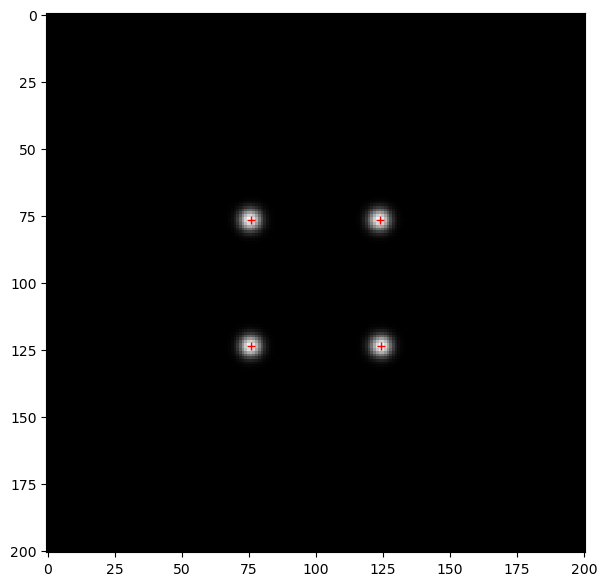

In [16]:
plt.figure(figsize=(7, 7))
plt.imshow(mb_coadd['mbexp']['i'].image.array, cmap='gray', interpolation='nearest')
plt.plot(obj_x-1, obj_y-1, 'r+')
#plt.plot(lists['shifts'][0].x, lists['shifts'][0].y, 'g+')
plt.show()

## Inference

In [17]:
def make_coadd_wcs(coadd_dm_wcs, coadd_dm_bbox):
    """
    make and return a wcs object

    NOTE: copy of make_wcs

    Parameters
    ----------

    Returns
    -------
    A galsim wcs object, currently a TanWCS
    """

    scale = coadd_dm_wcs.getPixelScale().asArcseconds()

    w_orig = coadd_dm_wcs.getSkyOrigin()
    ra = w_orig.getRa().asDegrees()
    dec = w_orig.getDec().asDegrees()
    world_origin = galsim.CelestialCoord(
        ra=ra*galsim.degrees,
        dec=dec*galsim.degrees,
    )

    coadd_dims = [coadd_dm_bbox.height, coadd_dm_bbox.width]
    coadd_cen = (np.array(coadd_dims)-1)/2
    image_origin = galsim.PositionD(x=coadd_cen[1], y=coadd_cen[0])
    

    mat = np.array(
        [[scale, 0.0],
         [0.0, scale]],
    )

    return galsim.TanWCS(
        affine=galsim.AffineTransform(
            mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1],
            origin=image_origin,
        ),
        world_origin=world_origin,
        units=galsim.arcsec,
    )

In [18]:
def get_model(all_pos, all_xshifts, all_yshifts, hlrs, all_fluxes, g1, g2, coadd_wcs, coadd_bbox):

    coadd_wcs = make_coadd_wcs(coadd_wcs, coadd_bbox)
    coadd_dims = [coadd_bbox.height, coadd_bbox.width]
    image = galsim.Image(coadd_dim, coadd_dim, wcs=coadd_wcs)

    # psf_gs_no_pix = get_psf(mb_coadd['mbexp']['i'])

    for pos, xshift, yshift, hlr, flux in zip(all_pos, all_xshifts, all_yshifts, hlrs, all_fluxes):

        image_pos = galsim.PositionD(x=pos[0]-xshift, y=pos[1]-yshift)
        local_wcs = coadd_wcs.local(image_pos=image_pos)

        gal = galsim.Gaussian(half_light_radius=hlr).withFlux(flux)
        gal = gal.shear(g1=g1, g2=g2)

        obj = galsim.Convolve([gal, psf_gs_no_pix])
        stamp = obj.drawImage(center=image_pos, wcs=local_wcs, method='no_pixel')

        b = stamp.bounds & image.bounds
        try:
            if b.isDefined():
                image[b] += stamp
        except:
            print("bounds:", stamp.bounds)
            print("hlr:", hlr)
            print("flux:", flux)
            print("shifts:", xshift, yshift)
            print("shear:", g1, g2)
            break

    return image.array

In [19]:
def log_prior(theta, nobj):
    xshifts = theta[:nobj]
    yshifts = theta[nobj:nobj*2]
    hlrs = theta[nobj*2:nobj*3]
    fluxes = theta[nobj*3:nobj*4]
    g1, g2 = theta[nobj*4:]
    if any((xshifts < -0.5) | (xshifts > 0.5)):
        return -np.inf
    if any((yshifts < -0.5) | (yshifts > 0.5)):
        return -np.inf
    if any((hlrs < 0.01) | (hlrs > 0.8)):
        return -np.inf
    if any((fluxes < 0) | (fluxes > 1e6)):
        return -np.inf
    if np.sqrt(g1**2 + g2**2) > 0.1:
        return -np.inf

    return 0.

In [24]:
coadd_img = mb_coadd['mbexp']['i'].image.array
# psf_gs_no_pix = get_psf(mb_coadd['mbexp']['i'])
psf_gs_no_pix = galsim.Gaussian(fwhm=FIXED_PSF_FWHM)
# coadd_img = data['band_data']['i'][0].image.array
inv_var = 1.  # /data['band_data']['i'][0].variance.array
all_pos = np.array([obj_x, obj_y]).T
coadd_wcs = data['coadd_wcs']
coadd_bbox = data['coadd_bbox']

In [25]:
def log_likelihood(theta,):
    nobj = len(all_pos)
    xshifts = theta[:nobj]
    yshifts = theta[nobj:nobj*2]
    hlrs = theta[nobj*2:nobj*3]
    fluxes = theta[nobj*3:nobj*4]
    g1, g2 = theta[nobj*4:]
    model = get_model(
        all_pos,
        xshifts,
        yshifts,
        hlrs,
        fluxes,
        g1,
        g2,
        coadd_wcs,
        coadd_bbox
    )
    return -0.5 * np.sum((coadd_img - model)**2 / inv_var)

In [26]:
def log_probability(theta):
    nobj = len(all_pos)
    lp = log_prior(theta, nobj)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [27]:
ndim = len(obj_x)*4 + 2
nwalkers = ndim*2
init_pos = np.concatenate([np.zeros(len(obj_x)), np.zeros(len(obj_x)), np.ones(len(obj_x))*0.4, np.ones(len(obj_x))*10_000])
init_pos = np.append(init_pos, 0.)
init_pos = np.append(init_pos, 0.)
pos = init_pos + np.concatenate(
    [
        1e-3 * np.random.randn(nwalkers, 2*len(obj_x)),
        1e-2 * np.random.randn(nwalkers, len(obj_x)),
        1e1 * np.random.randn(nwalkers, len(obj_x)),
        1e-3 * np.random.randn(nwalkers, 2)
    ],
    axis=1
)
# nwalkers, ndim = pos.shape
print(ndim, nwalkers)

18 36


In [32]:
with Pool(10) as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers,
        ndim,
        log_probability,
        pool=pool,
        live_dangerously=True,
    )
    res = sampler.run_mcmc(pos, 10_000, progress=True, skip_initial_state_check=True)

100%|██████████| 10000/10000 [03:11<00:00, 52.26it/s]


In [33]:
samples = sampler.get_chain()[:, :, -2:]
all_samples = sampler.get_chain()

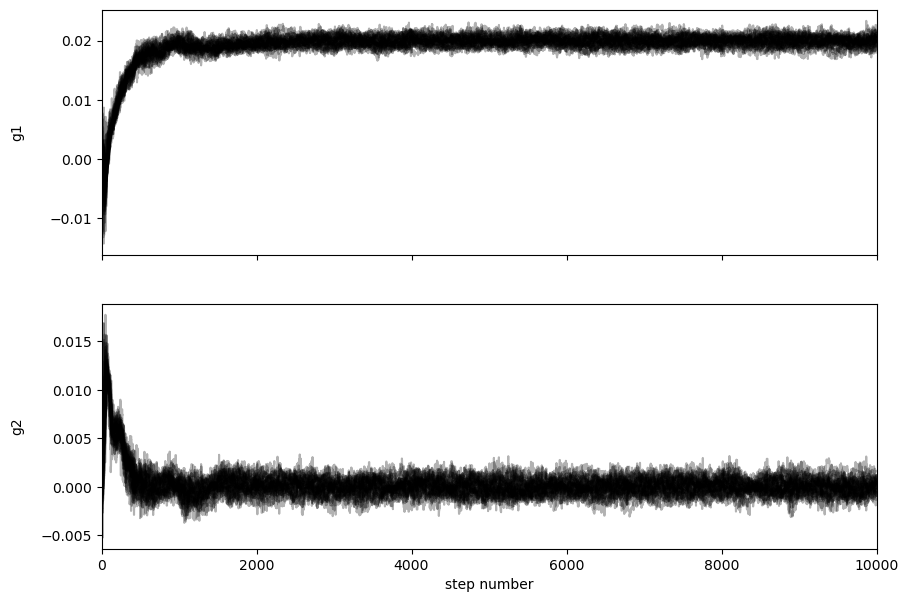

In [34]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
labels = ["g1", "g2"]
for i in range(2):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

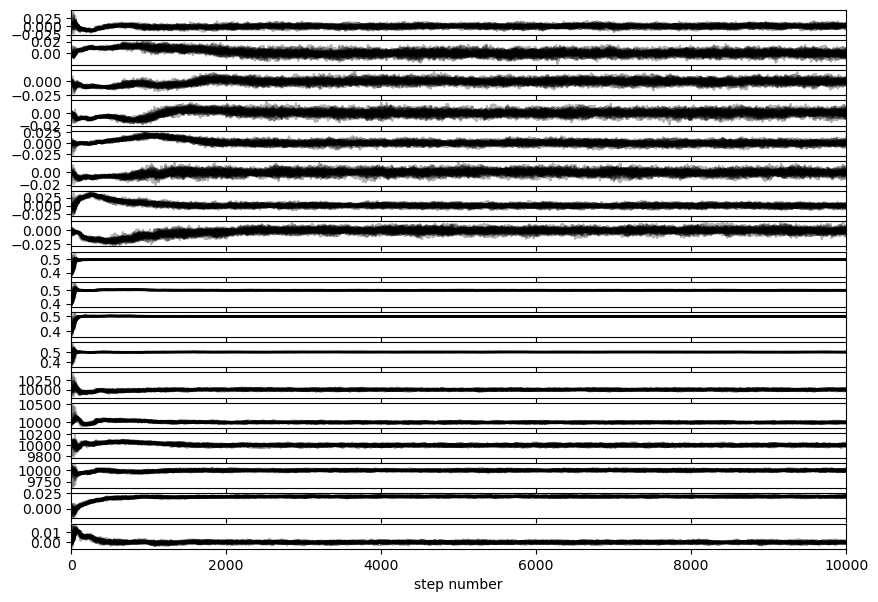

In [35]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
#labels = ["g1", "g2"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(all_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(all_samples))
    #ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [36]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 14 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [239.42430345 743.85097983 486.44670934 316.15379292 583.47596108
 446.4883119  611.88919311 788.51921124  76.59755826  47.93703917
  66.87396313  33.88300876 317.16506351 425.97746543 556.71711599
 429.97646158 539.21727998 243.16976536]

In [37]:
flat_samples = sampler.get_chain(discard=2_000, thin=10, flat=True)[:, -2:]
all_flat_samples = sampler.get_chain(discard=2_000, thin=10, flat=True)

In [38]:
np.median(all_flat_samples, axis=0)

array([ 1.61494386e-04,  3.78937596e-04,  1.11521390e-04, -2.66280600e-05,
        1.82574587e-04, -7.54930577e-05,  2.59521908e-04, -5.30625475e-05,
        4.99987919e-01,  4.99926808e-01,  4.99971236e-01,  5.00013140e-01,
        1.00002266e+04,  9.99876855e+03,  1.00004477e+04,  9.99984816e+03,
        1.99354871e-02,  2.99915242e-05])

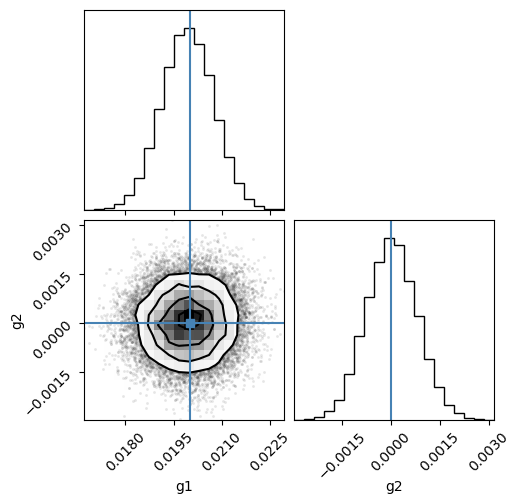

In [39]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[0.02, 0.]
);

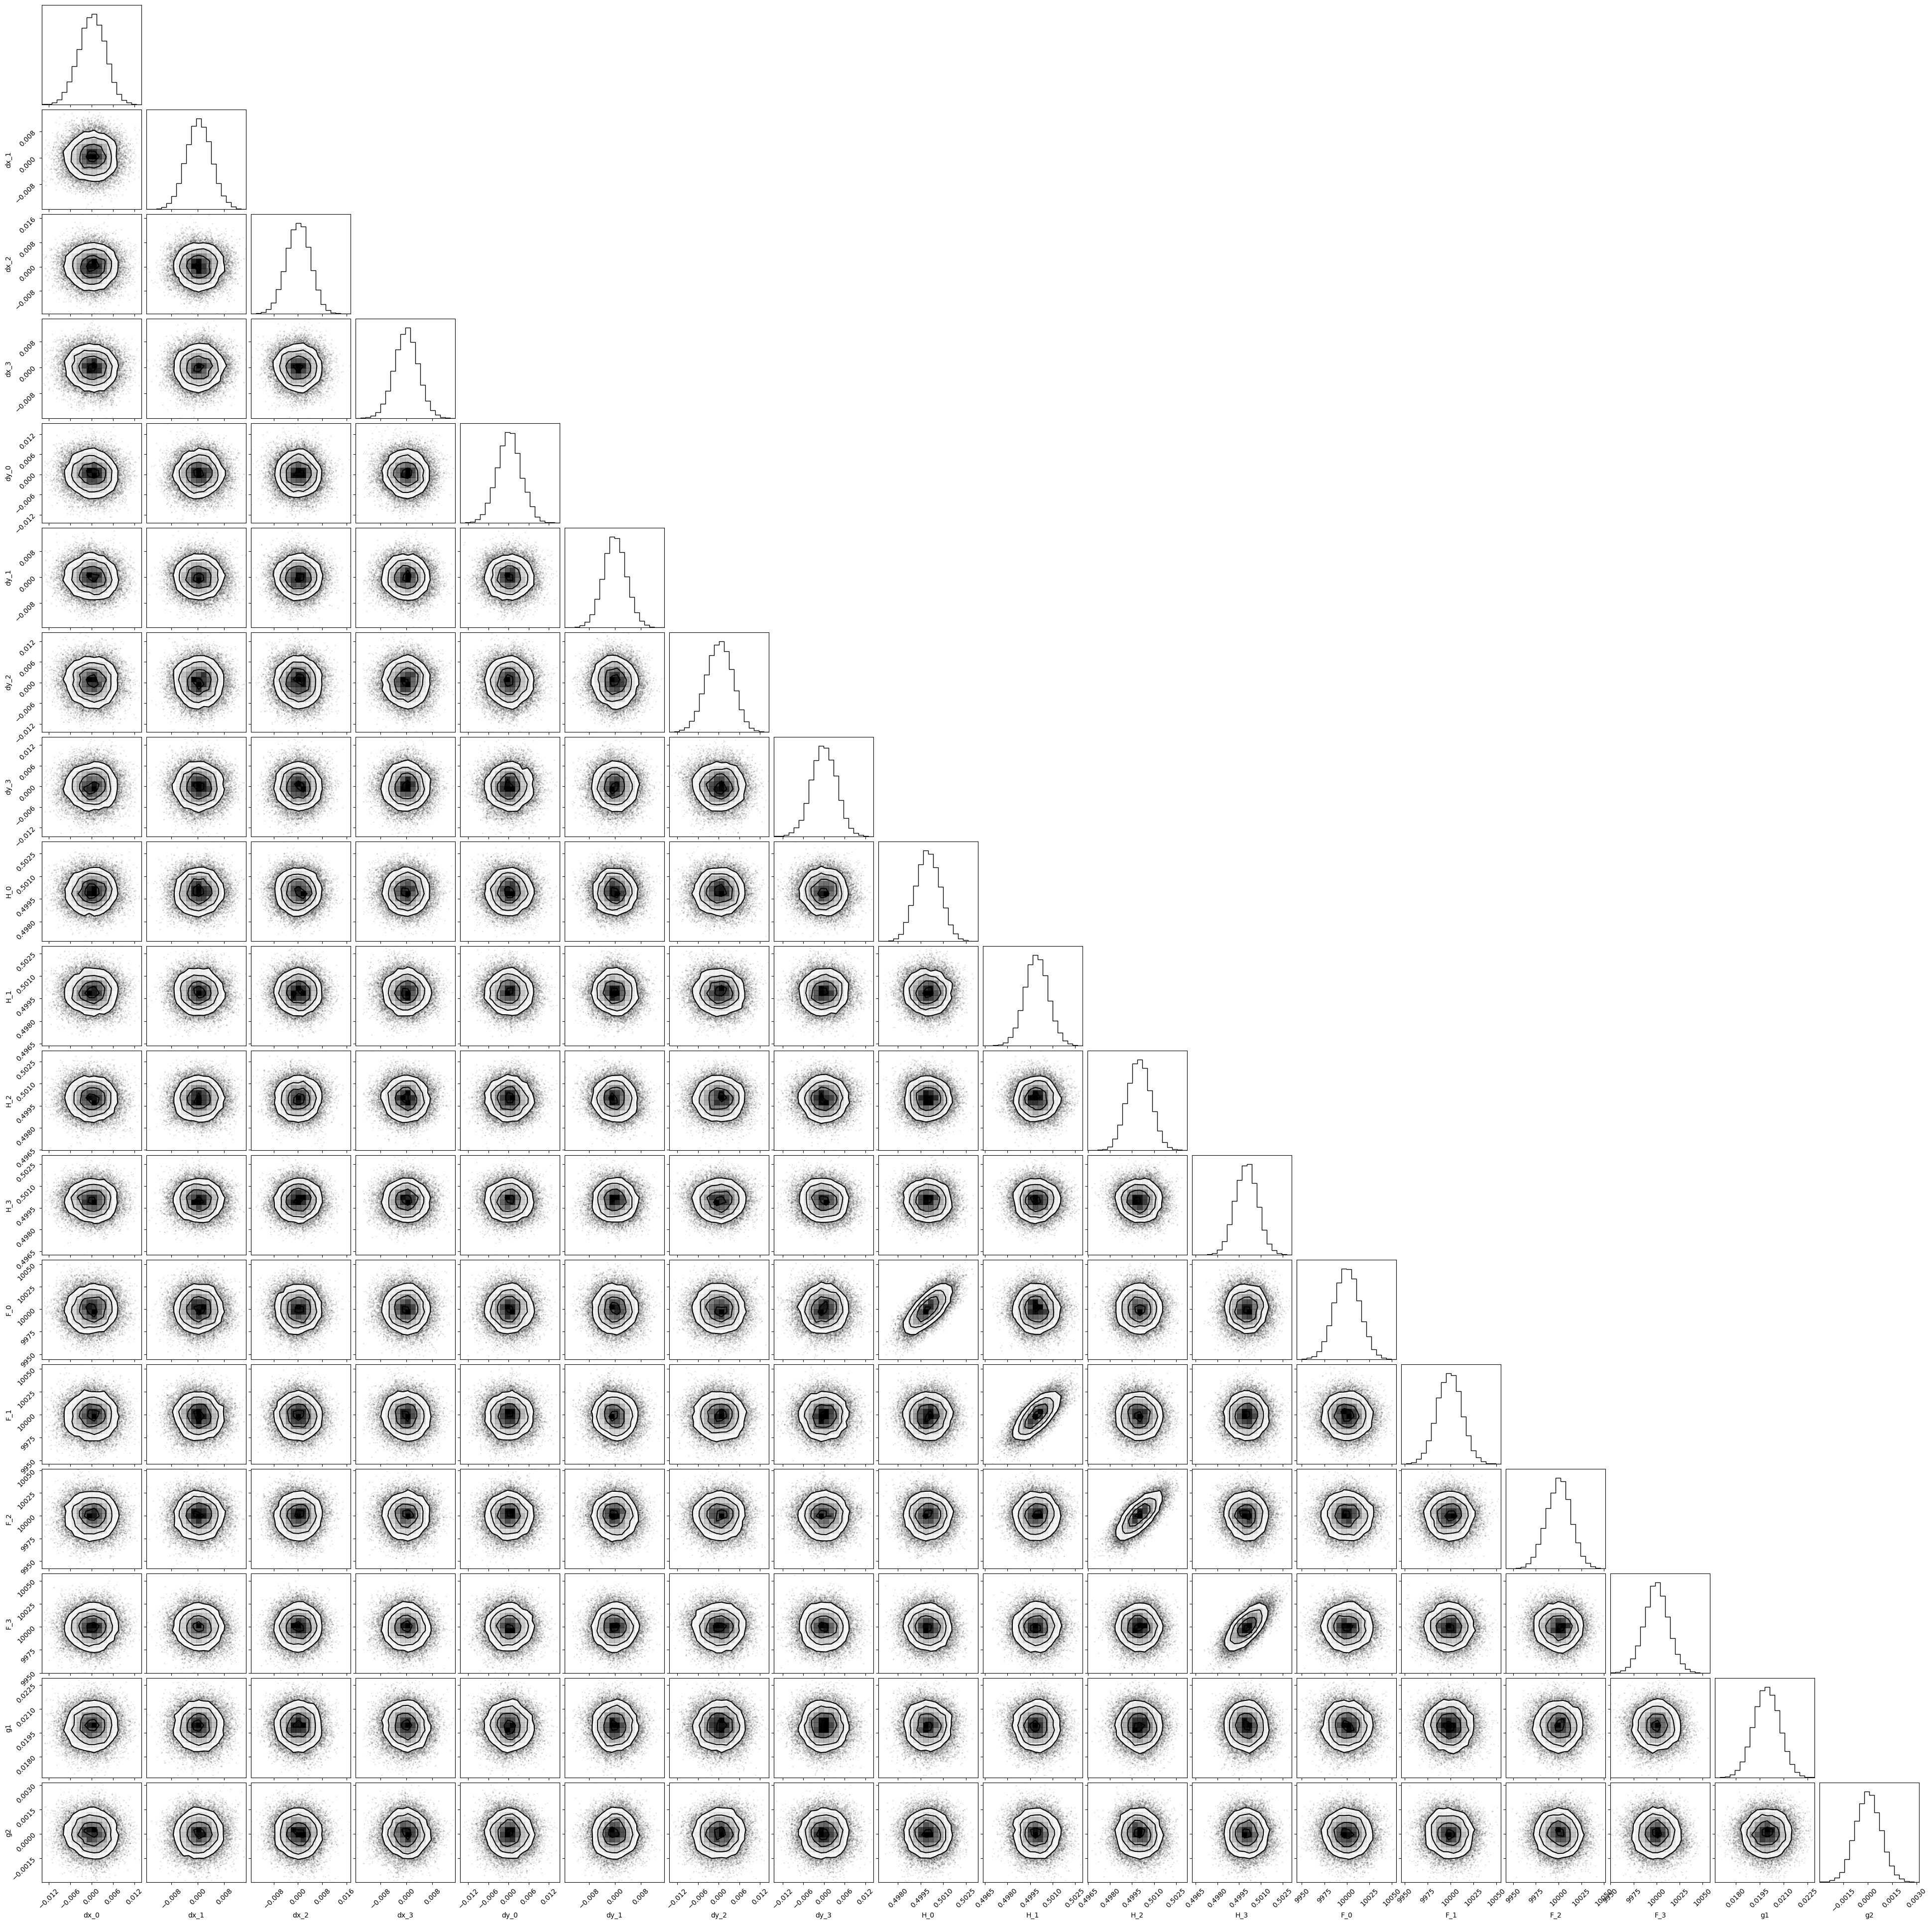

In [40]:
nobj = len(obj_x)
all_labels = [f"dx_{i}" for i in range(nobj)]
all_labels += [f"dy_{i}" for i in range(nobj)]
all_labels += [f"H_{i}" for i in range(nobj)]
all_labels += [f"F_{i}" for i in range(nobj)]
all_labels += ['g1', 'g2']
fig = corner.corner(
    all_flat_samples, labels=all_labels,
);

In [41]:
theta_test = np.concatenate([np.zeros(len(obj_x)), np.zeros(len(obj_x)), np.ones(len(obj_x))*0.3, np.ones(len(obj_x))])
theta_test = np.append(theta_test, 0.02)
theta_test = np.append(theta_test, 0.)
log_probability(theta_test)

-2151603.75

In [42]:
theta_test = np.concatenate([np.zeros(len(obj_x)), np.zeros(len(obj_x)), np.ones(len(obj_x))*0.5, np.ones(len(obj_x))])
theta_test = np.append(theta_test, 0.02)
theta_test = np.append(theta_test, 0.)
log_likelihood(theta_test)

-2151708.25

In [43]:
im_test = get_model(
    np.array([obj_x, obj_y]).T,
    np.zeros(len(obj_x)),
    np.zeros(len(obj_x)),
    np.ones(len(obj_x))*0.5,
    np.ones(len(obj_x)),
    0.02,
    0.,
    data['coadd_wcs'],
    data['coadd_bbox']
)

In [44]:
best_param = np.median(all_flat_samples, axis=0)
nobj = len(obj_x)
best_fit = get_model(
    np.array([obj_x, obj_y]).T,
    best_param[:nobj],
    best_param[nobj:nobj*2],
    best_param[nobj*2:nobj*3],
    best_param[nobj*3:nobj*4],
    best_param[-2],
    best_param[-1],
    data['coadd_wcs'],
    data['coadd_bbox']
)
log_likelihood(best_param)

-0.04556548222899437

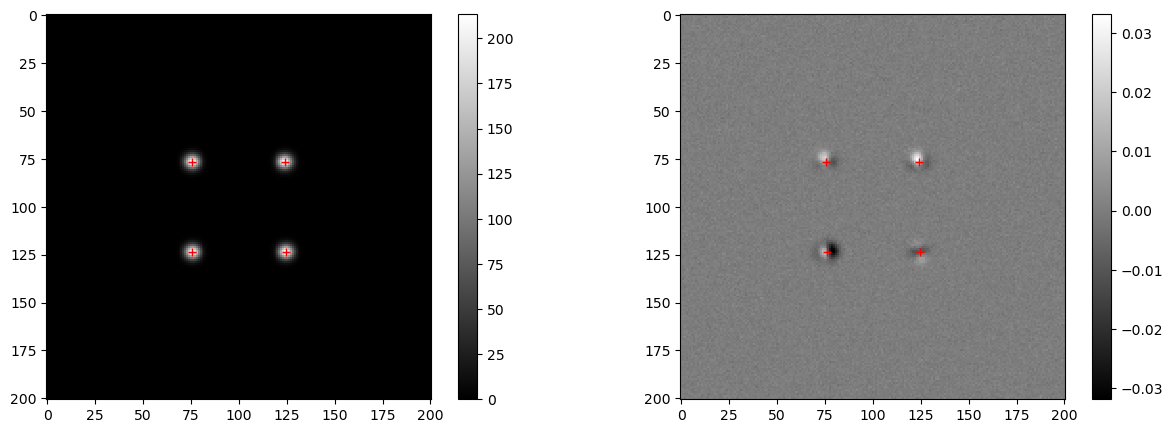

In [45]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
im = axs[0].imshow(best_fit, cmap='gray', interpolation='nearest')
axs[0].plot(obj_x-1, obj_y-1, 'r+')
plt.colorbar(im, ax=axs[0])

im = axs[1].imshow(best_fit-coadd_img, cmap='gray', interpolation='nearest')
axs[1].plot(obj_x-1, obj_y-1, 'r+')
plt.colorbar(im, ax=axs[1])